In [2]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer, quantize_apply


# from tensorflow.keras import layers
# from tensorflow_model_optimization.quantization.keras import quantize_model, QuantizeConfig
# from tensorflow_model_optimization.quantization.keras.default_8bit import Default8BitQuantizeScheme
import sys

print(sys.version)
print(tf.__version__)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [1]:
print(x_train[0])
print(x_train.shape)
x_train = transform.resize(x_train, (x_train.shape[0], 16, 16, 1))
x_test = transform.resize(x_test, (x_test.shape[0], 16, 16, 1))
x_train *= 256
x_train -= 128
x_train = x_train.astype(np.int8)
x_test *= 256
x_test -= 128
x_test = x_train.astype(np.int8)
print(x_train[0])

NameError: name 'x_train' is not defined

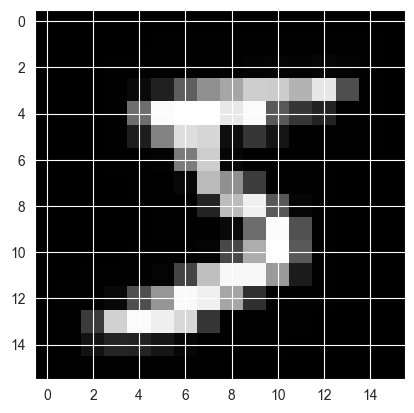

In [4]:
plt.imshow(x_train[0][:, :, 0], cmap='gray')

In [5]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
x_train_flat = x_train.reshape(x_train.shape[0], -1)  # Reshapes to (60000, 784)
x_test_flat = x_test.reshape(x_test.shape[0], -1)  # Reshapes to (10000, 784)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu')
])

model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

In [7]:
batch_size = 64
num_classes = 10
epochs = 5
history = model.fit(x_train_flat, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[])

Epoch 1/5
844/844 [==============================] - 1s 603us/step - loss: nan - acc: 0.1367 - val_loss: nan - val_acc: 0.0978
Epoch 2/5
844/844 [==============================] - 0s 535us/step - loss: nan - acc: 0.0988 - val_loss: nan - val_acc: 0.0978
Epoch 3/5
844/844 [==============================] - 0s 512us/step - loss: nan - acc: 0.0988 - val_loss: nan - val_acc: 0.0978
Epoch 4/5
844/844 [==============================] - 0s 506us/step - loss: nan - acc: 0.0988 - val_loss: nan - val_acc: 0.0978
Epoch 5/5
844/844 [==============================] - 0s 538us/step - loss: nan - acc: 0.0988 - val_loss: nan - val_acc: 0.0978


In [16]:
# def representative_dataset():
#   for data in x_test:
#     yield {
#       "image": data.image,
#       "bias": data.bias,
#     }

def representative_dataset():
    for _ in range(100):
      data = np.random.rand(1, 256) * 256 - 128
      yield [data.astype(np.int8)]

In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

quantized_model = converter.convert()

NameError: name 'representative_dataset' is not defined

In [ ]:
# SKIP IF RUNNING



In [18]:
np.set_printoptions(threshold=np.inf)

with open("weights_quantized.txt", "w") as f:
    for layer in quantized_model.layers:
        try:
            weights, biases = layer.get_weights()
            f.write(f"Weights for layer {layer.name}: {weights}\n")
            f.write(f"Biases for layer {layer.name}: {biases}\n")
        except: 
            pass
        finally:
            print(layer.get_weights())

AttributeError: 'bytes' object has no attribute 'layers'

In [19]:
with open("quantized_model.tflite", "wb") as f:
    f.write(quantized_model)

In [20]:
interpreter = tf.lite.Interpreter(model_content=quantized_model)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [21]:
for detail in interpreter.get_tensor_details():
    print(detail)
    if 'kernel' in detail['name'] or 'bias' in detail['name']:
        weights = interpreter.get_tensor(detail['index'])
        print(f"Weights for {detail['name']}: {weights}")

{'name': 'serving_default_dense_input:0', 'index': 0, 'shape': array([  1, 256], dtype=int32), 'shape_signature': array([ -1, 256], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'tfl.pseudo_qconst', 'index': 1, 'shape': array([10], dtype=int32), 'shape_signature': array([10], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([0.00296325, 0.00275972, 0.00389738, 0.00215799, 0.00357459,
       0.00354102, 0.0035162 , 0.00296185, 0.00419865, 0.00408445],
      dtype=float32), 'zero_points': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'tfl.pseudo_qconst1', 'index': 2, 'shape': array([10, 32], dtype=int32), 'shape_signature': array([10, 32], dtype=int32), 'dtype': <cla

In [22]:
interpreter.set_tensor(interpreter.get_input_details()[0]['index'], x_test_flat[2:3])
interpreter.invoke()
output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
print(output)
print(model.predict(x_test_flat[2:3]))

[[-128 -128 -125 -127   99 -128 -128 -115 -128 -115]]
1/1 [==============================] - 0s 35ms/step
[[1.3699658e-04 3.2315580e-05 5.9951176e-03 7.4129185e-04 8.8706261e-01
  3.1710009e-05 4.4171764e-05 4.1481465e-02 1.5146312e-03 6.2959626e-02]]


In [ ]:
# plt.imshow(x_test[0][:, :, 0], cmap='gray')
# print(x_test_flat[0:1])

test = x_test_flat[2:3]
test = test.reshape(16, 16)
print(test)
print(y_test[3])
plt.imshow(test, cmap='gray')

In [15]:
print((np.random.rand(1, 256) * 256 - 128).astype(np.int8))

[[ -72  -45  119   41  -75  -27   46  110   66  -32  -97   43 -103   87
   -16  -16  102   13   93  -58    3   -7   61  -43   91 -126   96    3
  -108   83  -88   52  -46    0 -124  115  -22  -97  -37   -6 -107 -110
     1   29  114  -17  114   97  -14   30   67   61   30   15  -46 -110
  -110   86  -12  -91   46  114   19   72  -24  -10   30  -17   38  -91
  -103  -17   13    7  102  -18  -64   79  -32  -57 -122  -19   74  -76
   -39  -25 -106  101  111   64  -64   33    5 -102  -40 -112 -110   30
   -86 -108  -36   -1 -119  120   52  -32  -66  -16   84   90  -59  -90
    93   33  -66  -79   36   28   67   10  111   37    2   92   58  -80
    57   33  112  -90   56  111   57  -70   70  115  112  -74  -14  -33
    87  109   60   13   56  -29  122   40  117   65  103   43  -90 -105
    75  -39   74   -9   -6 -120  -75    0  -69   60   61   98 -127  126
   -55  -98  -41   -4   54  -28  -35 -115  123  -27   22   11  -73   -4
   -15  -87   94  -72   28 -127  124 -104   57    7  -94   67   

In [23]:
tensor_details = interpreter.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization_parameters']['scales']
    zero_points = dict['quantization_parameters']['zero_points']
    tensor = interpreter.tensor(i)()

    print(i, type, tensor_name, scales.shape, zero_points.shape, tensor.shape)

0 <class 'type'> serving_default_dense_input:0 (0,) (0,) (1, 256)
1 <class 'type'> tfl.pseudo_qconst (10,) (10,) (10,)
2 <class 'type'> tfl.pseudo_qconst1 (10,) (10,) (10, 32)
3 <class 'type'> tfl.pseudo_qconst2 (32,) (32,) (32,)
4 <class 'type'> tfl.pseudo_qconst3 (32,) (32,) (32, 32)
5 <class 'type'> tfl.pseudo_qconst4 (32,) (32,) (32,)
6 <class 'type'> tfl.pseudo_qconst5 (32,) (32,) (32, 256)
7 <class 'type'> sequential/dense/Cast (0,) (0,) (1, 256)


ValueError: Tensor data is null. Run allocate_tensors() first

In [24]:
print(interpreter.get_tensor(6)) #Layer 1 weights

[[-117    4  -15  120   84  -49  -66    8   29  -21   -7  119   80  -49
    97   41   49  -13  -56  123  -87  -32   61   -7  -75  -47  -78   25
   124  124  118   91  -25    9  126   28   80  -24  -18  -23  -39   39
   -82  -45  125   19  127   24   30  -23  -75 -102  103 -116   62   90
    86   68  -83  125   -9 -106  -98  -66 -105  -70  -67  116   97  119
   -69  -24  -77 -122  -28   59  124  -26   22  115  -64   66  -21  -16
   -48   49  103  119   69  -53   19  -65  112   82  -37  123   90   53
   -25  -68  120  -64   36  -13   -8  -65   84  -43  101  103   19   49
     9    3  -55 -126  -85  -29  -76   -9   39  -74   18   89   95  -27
    40   14  -55   87   66    3   97  -85   20   36  -59  113  -87  -78
     5  110   26  -57  -66  -31   31  -91   80  -73   18   93  -37   68
    15  -39   58  120  -25   18  121  101    0  -23   64  118   63  -10
     3  -42  -23   83   61   69  121 -123   91  -17   54  -78   76  109
    77 -100   -6  112 -110  -44    5   38   86  127  117  -92   

In [25]:
print(interpreter.get_tensor(5)) #Layer 1 biases

[  0  -3   8  -7 -12  -5  -2   3  18   0  14  -8 -16 -14 -12 -11  -4  -5
  -6  -8 -17 -13 -10 -11 -11  -9 -17   6   2 -10  -7  -9]


In [26]:
print(interpreter.get_tensor(4)) #Layer 2 weights

[[ -89  -79  -38  -91  124  -19   29  127   -4  -92   -4   59  -61  -23
    87  -93  -36   62   32    9    9  -88   49  -56   -8   54  113   54
    34   12 -114  103]
 [-123  -43  -90   53   99  127  -12   26    4 -111  -17    3   68  -63
    71   42  101  -71  -46   56   87   95 -119 -110   59   54   95  103
   -84   90   19 -110]
 [ -12  -55   13  -39  -75    5   -7   59   30   88 -127   95   88   21
   113  -72  -10    8 -104   60   55  -10   77 -115   45  119   98 -104
   -76  -76  -83  -86]
 [  55  -37  -28  -56 -126  -12  -20    8  -14   83  -83   49  106   65
    13  -90  -82   49 -112   82  -22   61   51 -127    6  -71   79  -13
   100   28   16 -124]
 [ -57    1  -31   -8  -13  -48  -33  -19   -9  -31   -4   76   11   92
   -36   22   99  -66 -123   95   80  -98  103  -17  -37  115  -93   40
  -127  -39  -45   48]
 [  97  -96  -82   18  101  -73  -60   32  -50  115  -10   14   27  -81
   -10 -103  -98  -34   79   19   -1  126  127  -16   -5   43  -64  -43
    85  -10  104  -28

In [27]:
print(interpreter.get_tensor(3)) #Layer 2 biases

[ 14  -4 -34  -1 -34  -8 -23  -4  -3  15  -5   0 -11  -2 -18 -13 -44  -1
 -19 -26 -12 -16 -24   0 -17  -7 -13  -8 -27 -10 -33 -16]


In [28]:
print(interpreter.get_tensor(2)) #Layer 3 weights

[[-127  -46    6   36  -94   48   67   40   19    0 -108  -28   12  -48
    -8  -19   66   41  -59  -21  -68  -45  -67  -22   35  -18  -45   23
     6  -60  -49    3]
 [ -92  -43  -33   26  -80  -15 -109    5   69    7  -50  -56  -99  -66
   -63  -23  -11  -42 -127   12  -58   82  -70  -94   49  -70   10  -47
    54  -97  -96   -1]
 [ -47    7    8  -31   44  -39   27   23   31   13   42  -16  -11  -30
    47   -6    3   39 -127  -43  -39   54  -33  -48   11  -14    1  -30
   -61  -26   45    7]
 [ -82   73  -43   97    4    4  -63   50   63    5  -90   49  -99   36
    82   -9    3   21  -12   73  -90    4  -40 -127   62  -25  -18  -74
   -62   58    6   15]
 [ -78   60  -34  -79  -11   30  -43   37  -13    2  -37  -33  -22  -59
   -44  -14   -6    3  -40  -18   -6   48   44   21   42   -5  -26  -43
   -48 -127   28  -42]
 [ -39 -114   -6   -3  -31   -6   -2   11   40   21  -14  -29  -15   31
    18   -3 -127   84   38  -83   13  -40  -77   -2   36  -11    9   23
    57    6   33  -81

In [29]:
print(interpreter.get_tensor(1)) #Layer 3 biases

[-31  45  14  -7 -18  40  37 -36  29 -15]
